In [9]:
import pandas as pd
import numpy as np
import random

In [10]:
team_seasons = pd.read_csv('./data/processed/team_season_features.csv')
print(team_seasons.head(4))

   Season  TeamID  Games  Wins    WinPct  PointsScored_mean  PointsScored_std  \
0    2014    1101   21.0   2.0  0.095238          63.142857         14.203118   
1    2015    1101   28.0   7.0  0.250000          61.000000         16.154348   
2    2016    1101   27.0   9.0  0.333333          69.851852         11.792122   
3    2017    1101   25.0   9.0  0.360000          67.880000         11.519259   

   PointsAllowed_mean  PointsAllowed_std   FGM_mean  ...  conf_tourney_winpct  \
0           78.619048          11.517275  20.333333  ...                  NaN   
1           71.857143          10.868624  21.428571  ...                  NaN   
2           76.259259          11.271450  23.814815  ...                  NaN   
3           72.640000          10.387813  24.440000  ...                  NaN   

   conf_tourney_points_ratio  days_until_tourney  conf_tourney_champion  \
0                        NaN                 NaN                    NaN   
1                        NaN          

In [11]:
previous_tourney_matchups = pd.read_csv('./data/raw/mens/MNCAATourneyCompactResults.csv')

In [8]:
print(team_seasons.head(4))

   Season  TeamID  Games  Wins    WinPct  PointsScored_mean  PointsScored_std  \
0    2014    1101   21.0   2.0  0.095238          63.142857         14.203118   
1    2015    1101   28.0   7.0  0.250000          61.000000         16.154348   
2    2016    1101   27.0   9.0  0.333333          69.851852         11.792122   
3    2017    1101   25.0   9.0  0.360000          67.880000         11.519259   

   PointsAllowed_mean  PointsAllowed_std   FGM_mean  ...  conf_tourney_winpct  \
0           78.619048          11.517275  20.333333  ...                  NaN   
1           71.857143          10.868624  21.428571  ...                  NaN   
2           76.259259          11.271450  23.814815  ...                  NaN   
3           72.640000          10.387813  24.440000  ...                  NaN   

   conf_tourney_points_ratio  days_until_tourney  conf_tourney_champion  \
0                        NaN                 NaN                    NaN   
1                        NaN          

In [12]:
# Step 1: Filter tournament games from 2003 onwards
tourney_games = previous_tourney_matchups[previous_tourney_matchups['Season'] >= 2003].copy()
print(f"Number of tournament games from 2003 onwards: {len(tourney_games)}")

# Step 2: Randomize team assignment
def randomize_teams(df):
    """
    Randomly assign teams as TeamA and TeamB to avoid bias in the prediction model.
    Returns a dataframe with TeamA/TeamB IDs and a binary target indicating if TeamA won.
    """
    result_df = df.copy()
    
    # Create arrays to store the randomized teams and outcome
    teamA_ids = []
    teamB_ids = []
    teamA_scores = []
    teamB_scores = []
    teamA_won = []
    
    # For each game, randomly decide which team is A and which is B
    for _, game in df.iterrows():
        # Randomly decide if winner is TeamA (coin flip)
        if random.random() < 0.5:
            # Winner is TeamA
            teamA_ids.append(game['WTeamID'])
            teamB_ids.append(game['LTeamID'])
            teamA_scores.append(game['WScore'])
            teamB_scores.append(game['LScore'])
            teamA_won.append(1)  # TeamA won
        else:
            # Winner is TeamB
            teamA_ids.append(game['LTeamID'])
            teamB_ids.append(game['WTeamID'])
            teamA_scores.append(game['LScore'])
            teamB_scores.append(game['WScore'])
            teamA_won.append(0)  # TeamB won
    
    # Add the new columns to the dataframe
    result_df['TeamAID'] = teamA_ids
    result_df['TeamBID'] = teamB_ids
    result_df['TeamAScore'] = teamA_scores
    result_df['TeamBScore'] = teamB_scores
    result_df['TeamA_Won'] = teamA_won
    
    # Keep only necessary columns
    columns_to_keep = ['Season', 'DayNum', 'TeamAID', 'TeamBID', 
                       'TeamAScore', 'TeamBScore', 'TeamA_Won', 'WLoc', 'NumOT']
    return result_df[columns_to_keep]

# Apply the randomization
randomized_games = randomize_teams(tourney_games)
print("\nFirst few rows of randomized games:")
print(randomized_games.head())

Number of tournament games from 2003 onwards: 1315

First few rows of randomized games:
      Season  DayNum  TeamAID  TeamBID  TeamAScore  TeamBScore  TeamA_Won  \
1136    2003     134     1411     1421          84          92          0   
1137    2003     136     1112     1436          80          51          1   
1138    2003     136     1272     1113          71          84          0   
1139    2003     136     1141     1166          79          73          1   
1140    2003     136     1301     1143          74          76          0   

     WLoc  NumOT  
1136    N      1  
1137    N      0  
1138    N      0  
1139    N      0  
1140    N      1  


In [13]:
# Step 3: Merge team season statistics for both teams
def add_team_features(games_df, stats_df):
    """
    Add team season statistics for both TeamA and TeamB.
    """
    # First, join TeamA features
    merged_df = games_df.merge(
        stats_df,
        left_on=['Season', 'TeamAID'],
        right_on=['Season', 'TeamID'],
        how='left',
        suffixes=('', '_drop')
    )
    
    # Drop duplicate columns and rename columns with TeamA prefix
    teamA_cols = [col for col in merged_df.columns if col not in games_df.columns and not col.endswith('_drop')]
    for col in teamA_cols:
        merged_df.rename(columns={col: f'TeamA_{col}'}, inplace=True)
    
    # Drop columns with _drop suffix
    merged_df = merged_df.drop([col for col in merged_df.columns if col.endswith('_drop')], axis=1)
    
    # Then, join TeamB features
    merged_df = merged_df.merge(
        stats_df,
        left_on=['Season', 'TeamBID'],
        right_on=['Season', 'TeamID'],
        how='left',
        suffixes=('', '_drop')
    )
    
    # Drop duplicate columns and rename columns with TeamB prefix
    teamB_cols = [col for col in merged_df.columns if col not in games_df.columns 
                 and not col.endswith('_drop') 
                 and not col.startswith('TeamA_') 
                 and col != 'TeamID']
    for col in teamB_cols:
        merged_df.rename(columns={col: f'TeamB_{col}'}, inplace=True)
    
    # Drop columns with _drop suffix and TeamID column
    merged_df = merged_df.drop([col for col in merged_df.columns if col.endswith('_drop') or col == 'TeamID'], axis=1)
    
    return merged_df

# Apply the team feature merging
final_dataset = add_team_features(randomized_games, team_seasons)

In [14]:
# Display the shape and a sample of the final dataset
print(f"\nFinal dataset shape: {final_dataset.shape}")
print("\nSample of final dataset columns:")
print(final_dataset.columns[:10].tolist() + ['...'] + final_dataset.columns[-10:].tolist())
print("\nFirst 3 rows of the final dataset (first few columns):")
print(final_dataset[['Season', 'DayNum', 'TeamAID', 'TeamBID', 'TeamA_Won', 'TeamAScore', 'TeamBScore']].head(3))


Final dataset shape: (1315, 120)

Sample of final dataset columns:
['Season', 'DayNum', 'TeamAID', 'TeamBID', 'TeamAScore', 'TeamBScore', 'TeamA_Won', 'WLoc', 'NumOT', 'TeamA_TeamID', '...', 'TeamB_conf_tourney_winpct', 'TeamB_conf_tourney_points_ratio', 'TeamB_days_until_tourney', 'TeamB_conf_tourney_champion', 'TeamB_CoachName', 'TeamB_RegularSeasonWinPct', 'TeamB_TournamentWinPct', 'TeamB_Experience', 'TeamB_RegularSeasonGames', 'TeamB_TournamentGames']

First 3 rows of the final dataset (first few columns):
   Season  DayNum  TeamAID  TeamBID  TeamA_Won  TeamAScore  TeamBScore
0    2003     134     1411     1421          0          84          92
1    2003     136     1112     1436          1          80          51
2    2003     136     1272     1113          0          71          84


In [15]:
print(final_dataset.head(3))

   Season  DayNum  TeamAID  TeamBID  TeamAScore  TeamBScore  TeamA_Won WLoc  \
0    2003     134     1411     1421          84          92          0    N   
1    2003     136     1112     1436          80          51          1    N   
2    2003     136     1272     1113          71          84          0    N   

   NumOT  TeamA_TeamID  ...  TeamB_conf_tourney_winpct  \
0      1          1411  ...                        1.0   
1      0          1112  ...                        1.0   
2      0          1272  ...                        0.0   

   TeamB_conf_tourney_points_ratio  TeamB_days_until_tourney  \
0                         1.078341                       8.0   
1                         1.214286                       1.0   
2                         0.987952                       3.0   

   TeamB_conf_tourney_champion   TeamB_CoachName  TeamB_RegularSeasonWinPct  \
0                          1.0  eddie_biedenbach                      0.448   
1                          1.0     

Shape of winning teams dataset: (1315, 58)

Summary statistics for winning teams:
                         mean       std        min        max
Games               31.882129  2.209487  21.000000  35.000000
Wins                24.659316  3.747081  11.000000  34.000000
WinPct               0.772714  0.099620   0.366667   1.000000
PointsScored_mean   75.469339  5.198464  58.812500  92.115385
PointsScored_std    11.365593  1.649871   6.513675  16.594427
PointsAllowed_mean  65.135167  4.560637  50.750000  79.735294
PointsAllowed_std   11.196776  1.547398   6.678510  15.980338
FGM_mean            26.719293  2.127151  20.558824  34.153846
FGA_mean            57.499480  3.449382  46.121212  66.878788
FGM3_mean            7.105008  1.402330   2.689655  11.411765


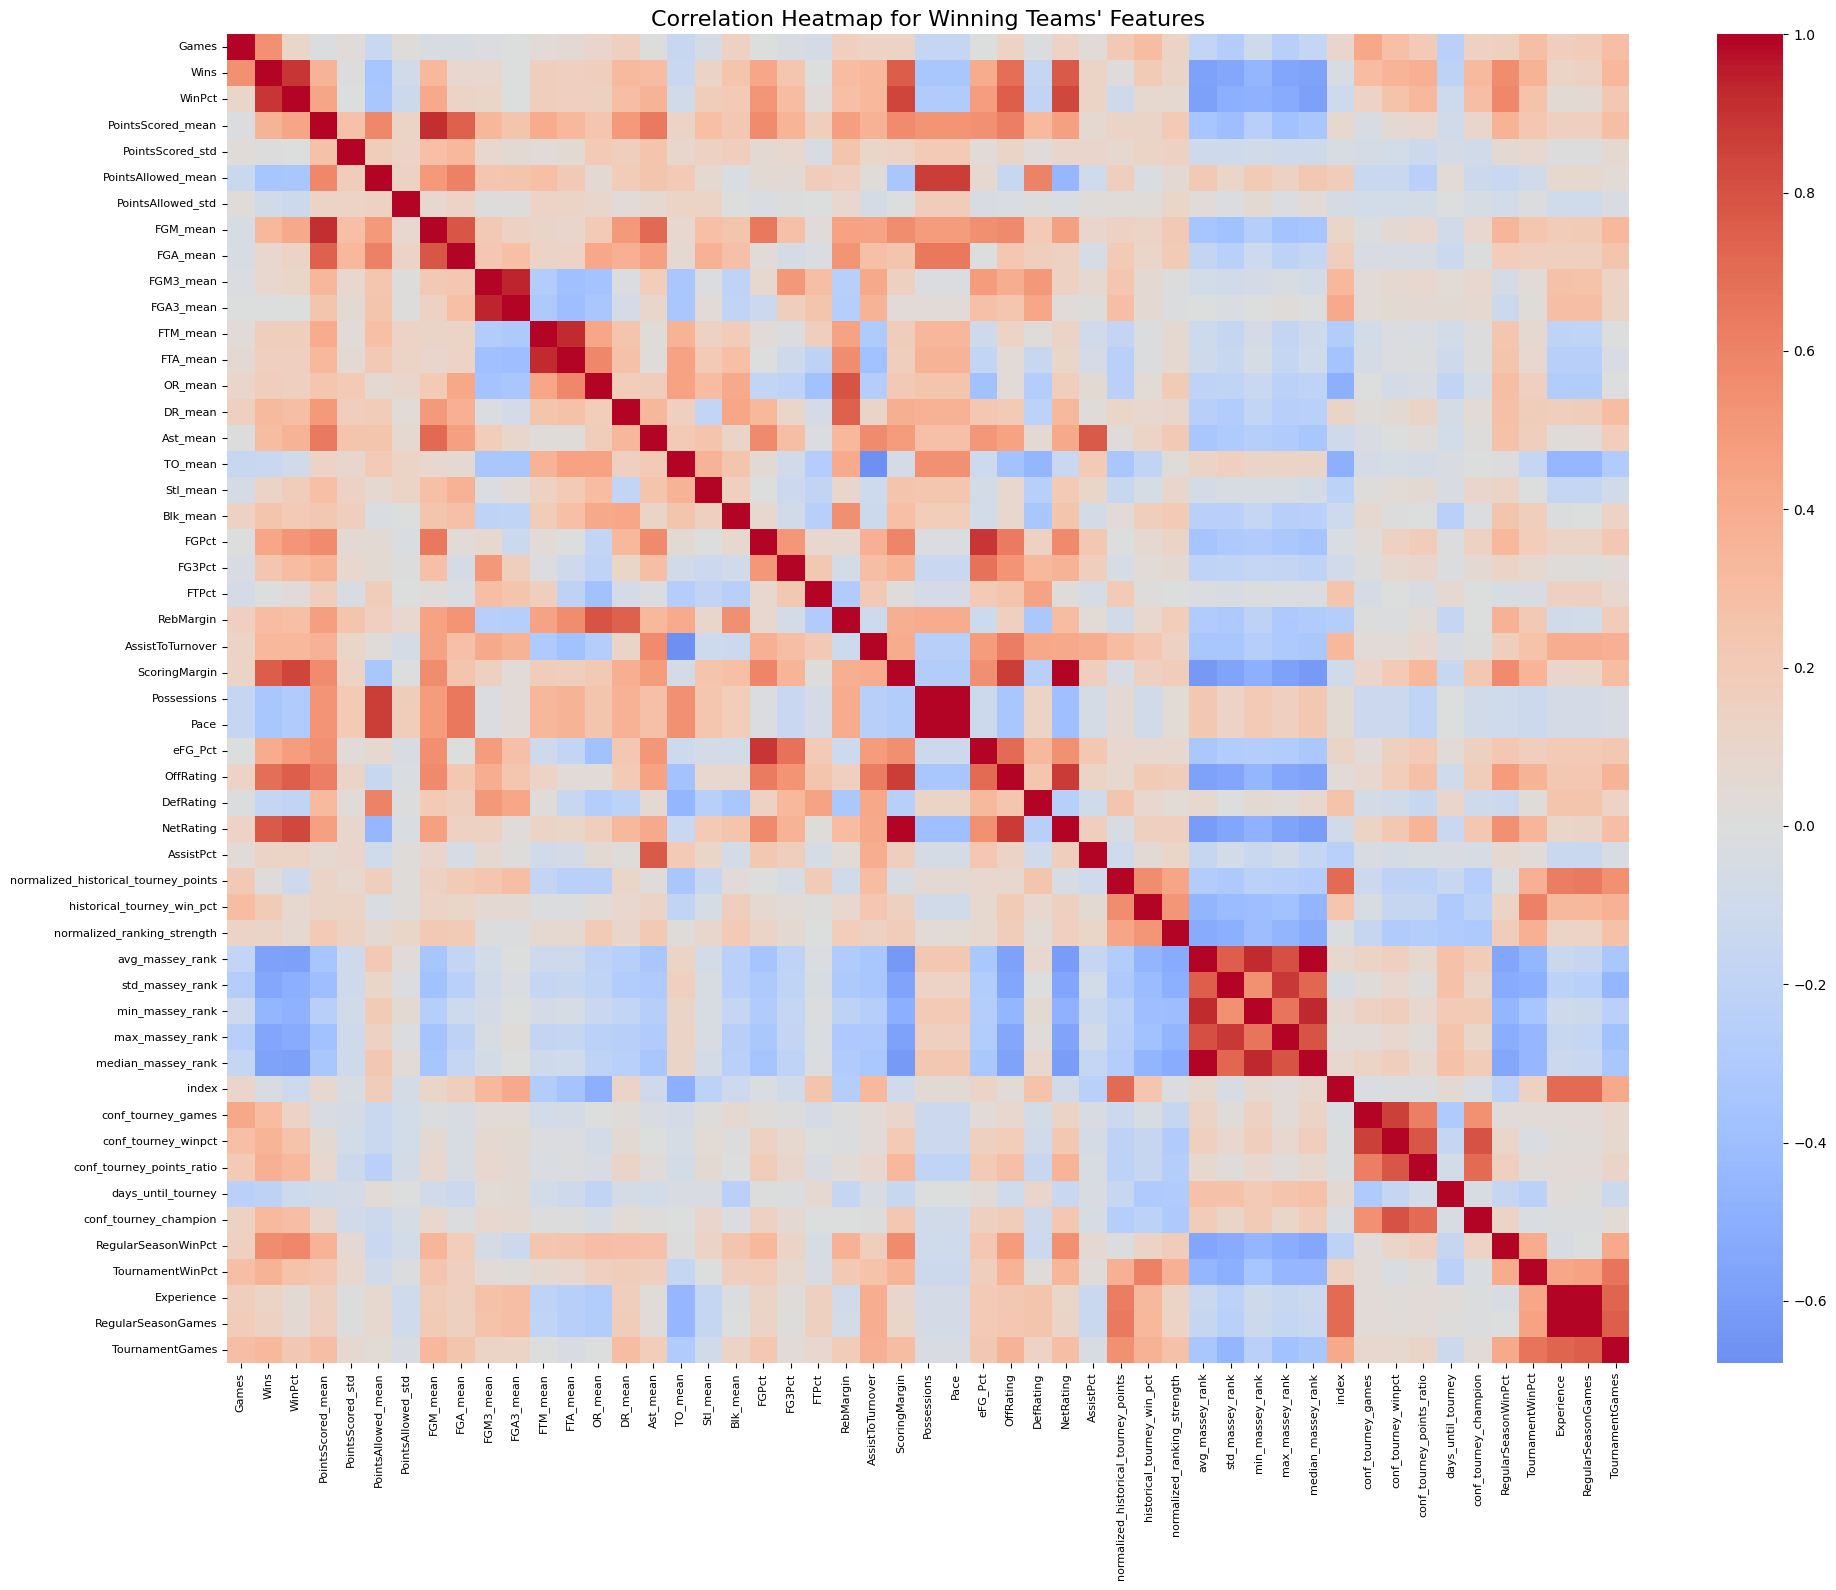

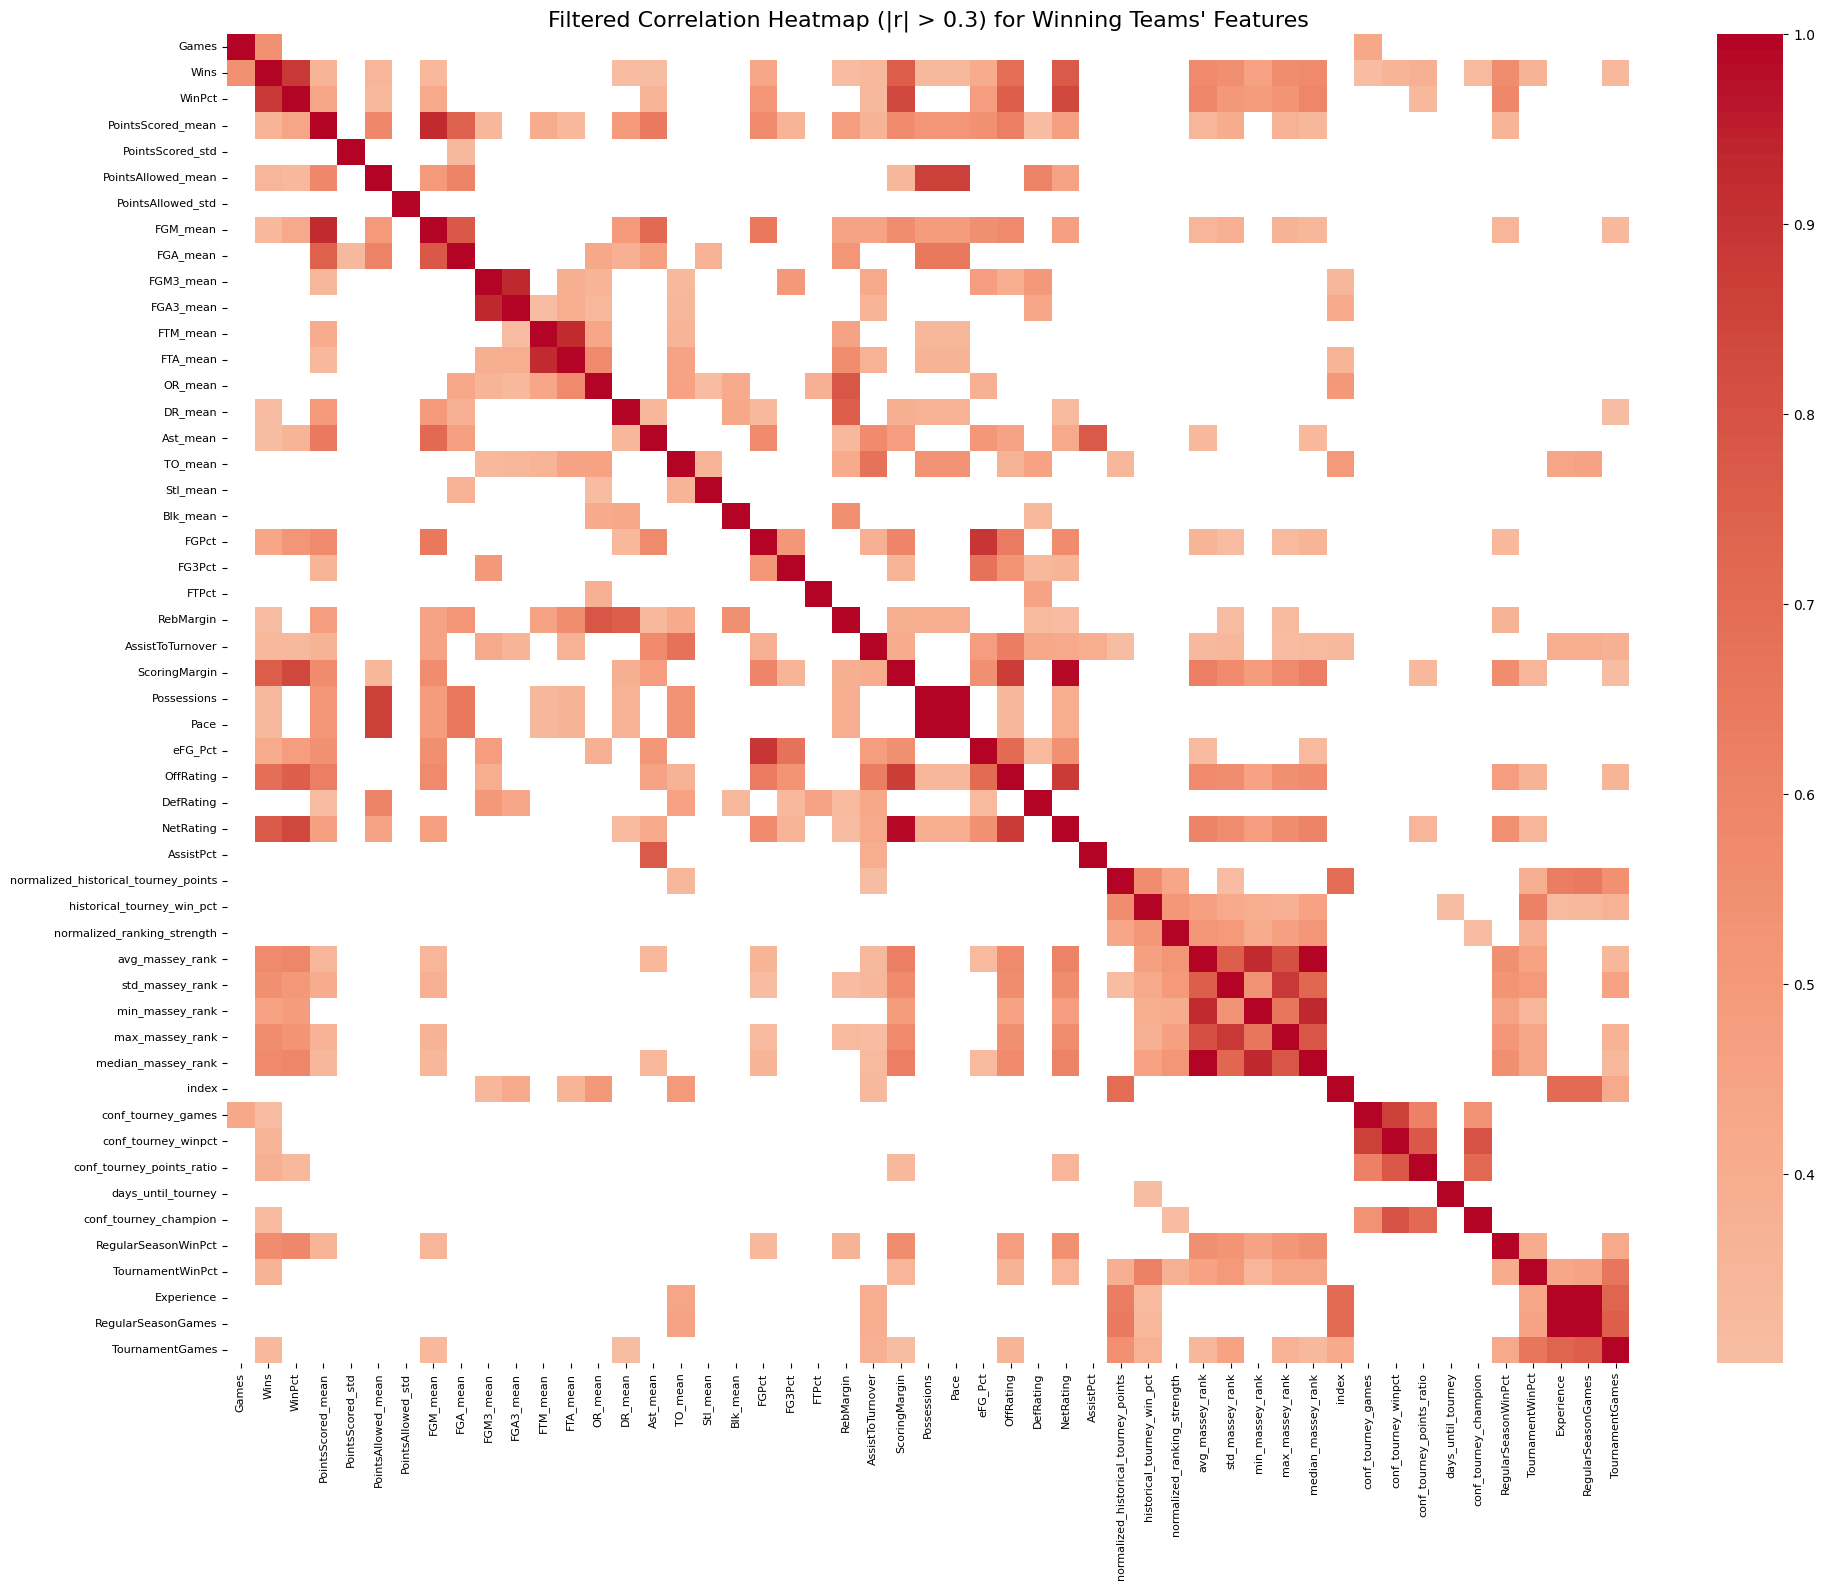


Top 15 strongly correlated feature pairs:
Possessions and Pace: 1.000
Experience and RegularSeasonGames: 0.998
avg_massey_rank and median_massey_rank: 0.998
ScoringMargin and NetRating: 0.989
FGM3_mean and FGA3_mean: 0.936
min_massey_rank and median_massey_rank: 0.929
FTM_mean and FTA_mean: 0.926
avg_massey_rank and min_massey_rank: 0.925
PointsScored_mean and FGM_mean: 0.921
FGPct and eFG_Pct: 0.891
Wins and WinPct: 0.890
std_massey_rank and max_massey_rank: 0.885
OffRating and NetRating: 0.879
ScoringMargin and OffRating: 0.873
PointsAllowed_mean and Possessions: 0.864


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify winning team features for each game
def get_winning_team_features(dataset):
    winning_features = []
    
    for idx, row in dataset.iterrows():
        # Extract all feature columns (excluding metadata)
        team_a_cols = [col for col in dataset.columns if col.startswith('TeamA_') and col != 'TeamA_Won']
        team_b_cols = [col for col in dataset.columns if col.startswith('TeamB_')]
        
        # Create a dictionary to hold winning team features
        winning_data = {}
        
        # Determine which team won and get their features
        if row['TeamA_Won'] == 1:
            # TeamA won
            for col in team_a_cols:
                feature_name = col.replace('TeamA_', '')
                winning_data[feature_name] = row[col]
        else:
            # TeamB won
            for col in team_b_cols:
                feature_name = col.replace('TeamB_', '')
                winning_data[feature_name] = row[col]
        
        # Add season and game ID for reference
        winning_data['Season'] = row['Season']
        winning_data['GameID'] = idx
        
        winning_features.append(winning_data)
    
    return pd.DataFrame(winning_features)

# Get winning team features
winning_teams_df = get_winning_team_features(final_dataset)

# Display basic statistics for the winning teams
print(f"Shape of winning teams dataset: {winning_teams_df.shape}")
print("\nSummary statistics for winning teams:")
print(winning_teams_df.describe().T[['mean', 'std', 'min', 'max']].head(10))

# Select numerical features for correlation analysis
# Exclude categorical/text features and identifiers
numerical_features = winning_teams_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_features = [col for col in numerical_features if col not in ['Season', 'GameID', 'TeamID']]

# Calculate correlation matrix
correlation_matrix = winning_teams_df[numerical_features].corr()

# Create a more readable subset by filtering strong correlations
# Keep correlations with absolute value above threshold
threshold = 0.3
filtered_corr = correlation_matrix.abs()
filtered_corr = filtered_corr.where(filtered_corr > threshold, np.nan)

# Create heatmap figure
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
           xticklabels=True, yticklabels=True)
plt.title('Correlation Heatmap for Winning Teams\' Features', fontsize=16)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

# Create a filtered heatmap for stronger correlations
plt.figure(figsize=(20, 16))
sns.heatmap(filtered_corr, annot=False, cmap='coolwarm', center=0, 
           xticklabels=True, yticklabels=True)
plt.title('Filtered Correlation Heatmap (|r| > 0.3) for Winning Teams\' Features', fontsize=16)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

# Let's also identify the top pairs of highly correlated features
corr_pairs = []
for i in range(len(numerical_features)):
    for j in range(i+1, len(numerical_features)):
        feature1 = numerical_features[i]
        feature2 = numerical_features[j]
        corr_value = correlation_matrix.loc[feature1, feature2]
        if abs(corr_value) > 0.7:  # Strong correlation threshold
            corr_pairs.append((feature1, feature2, corr_value))

# Sort by absolute correlation value
corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

# Display top correlated pairs
print("\nTop 15 strongly correlated feature pairs:")
for feature1, feature2, corr in corr_pairs[:15]:
    print(f"{feature1} and {feature2}: {corr:.3f}")

Found 55 common features to compare
Numeric features: 51
Non-numeric features: 4
Top 15 Statistics Most Indicative of Winning Teams (largest effect sizes):
                                 Feature  Winner_Mean  Loser_Mean  \
46                         ScoringMargin    10.334172    7.713392   
48                             NetRating    16.505962   12.226996   
35                             OffRating   119.471658  115.403163   
33           normalized_ranking_strength     0.701508    0.475247   
15                                  Wins    24.659316   22.751331   
3                    RegularSeasonWinPct     0.704512    0.654976   
2                       TournamentWinPct     0.431691    0.292034   
45                                WinPct     0.772714    0.725177   
1             historical_tourney_win_pct     0.508844    0.412627   
49                       TournamentGames    12.738732    7.420168   
25                              FGM_mean    26.719293   25.971632   
16  normalized_h

/var/folders/_0/lfzv1d311sjbpc94z2sh41m80000gn/T/ipykernel_54886/4198087072.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Effect_Size', y='Feature', data=top_results, palette='viridis')


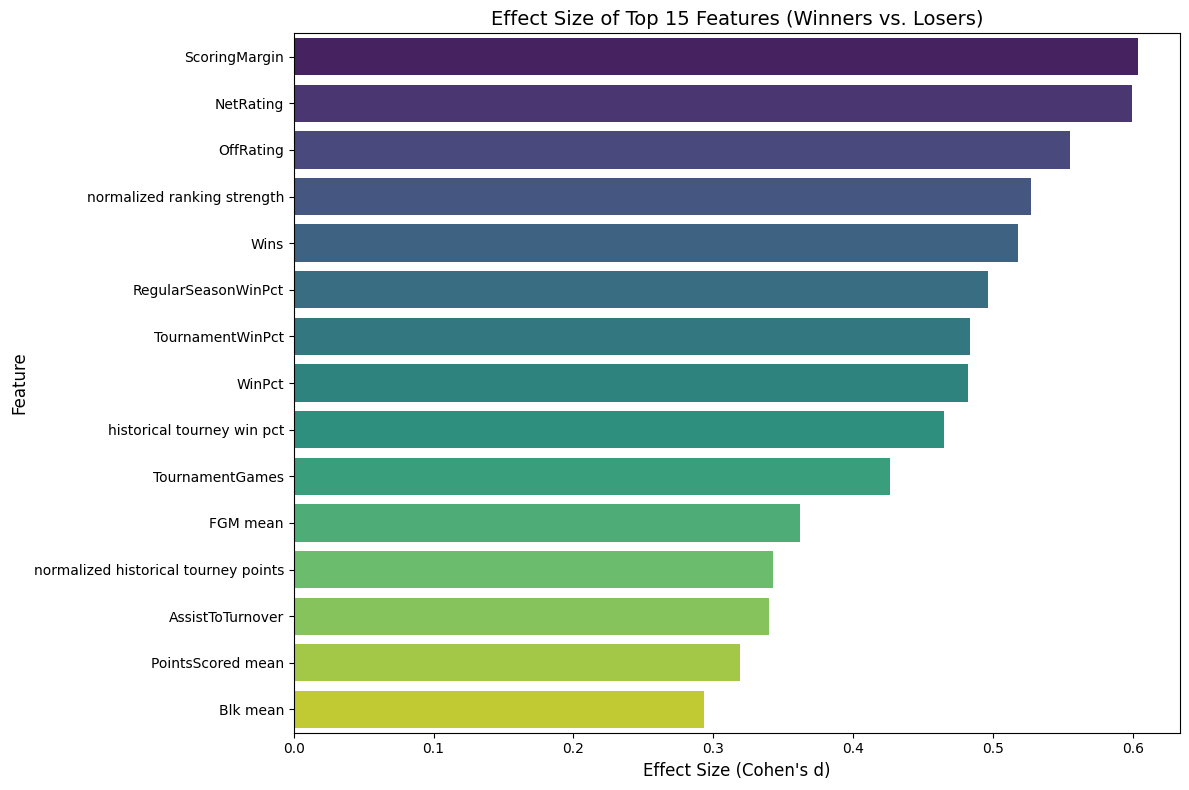

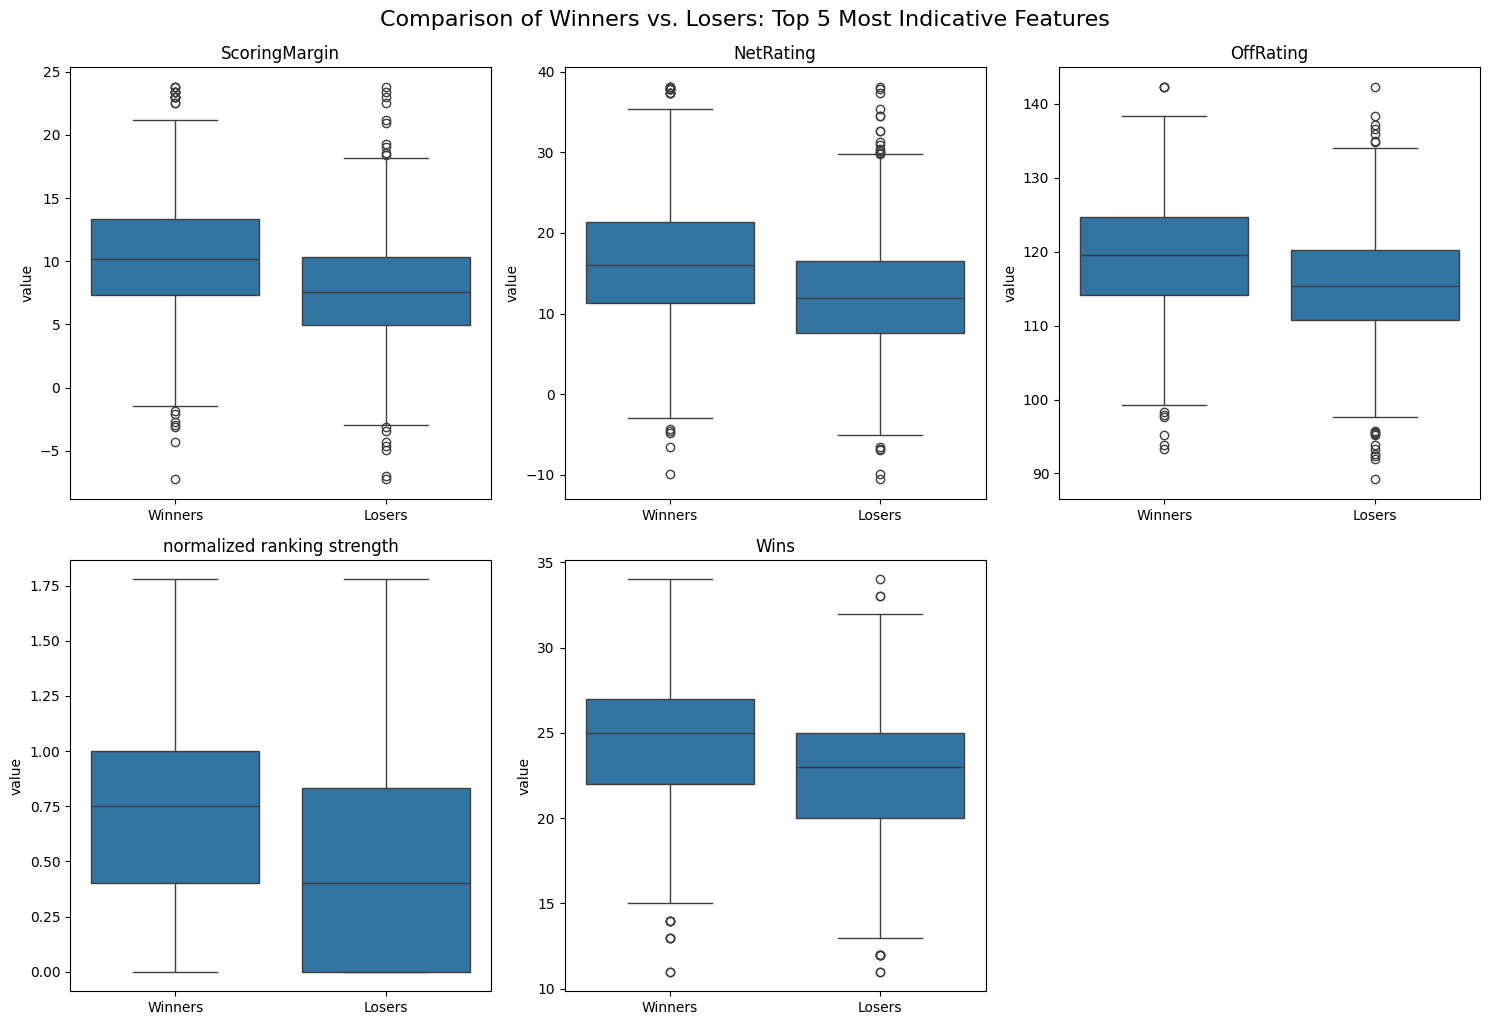

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Create a dataset that pairs winning and losing team features for direct comparison
def create_comparison_dataset(dataset):
    comparisons = []
    
    # Get all TeamA and TeamB columns
    teamA_cols = [col for col in dataset.columns if col.startswith('TeamA_') and col != 'TeamA_Won']
    teamB_cols = [col for col in dataset.columns if col.startswith('TeamB_')]
    
    # Extract feature names and make sure they exist for both teams
    teamA_features = [col.replace('TeamA_', '') for col in teamA_cols]
    teamB_features = [col.replace('TeamB_', '') for col in teamB_cols]
    
    # Find common features that exist for both TeamA and TeamB
    common_features = set(teamA_features).intersection(set(teamB_features))
    
    print(f"Found {len(common_features)} common features to compare")
    
    # Identify which features are numeric
    numeric_features = []
    non_numeric_features = []
    
    for feature in common_features:
        if np.issubdtype(dataset[f'TeamA_{feature}'].dtype, np.number):
            numeric_features.append(feature)
        else:
            non_numeric_features.append(feature)
    
    print(f"Numeric features: {len(numeric_features)}")
    print(f"Non-numeric features: {len(non_numeric_features)}")
    
    for idx, row in dataset.iterrows():
        # Determine which team won
        if row['TeamA_Won'] == 1:
            winning_prefix = 'TeamA_'
            losing_prefix = 'TeamB_'
        else:
            winning_prefix = 'TeamB_'
            losing_prefix = 'TeamA_'
        
        # Create a record for this game
        game_data = {
            'Season': row['Season'],
            'DayNum': row['DayNum'],
            'GameID': idx
        }
        
        # Process numeric features with difference calculation
        for feature in numeric_features:
            winner_val = row[f'{winning_prefix}{feature}']
            loser_val = row[f'{losing_prefix}{feature}']
            
            # Add winning and losing team values
            game_data[f'Winner_{feature}'] = winner_val
            game_data[f'Loser_{feature}'] = loser_val
            
            # Calculate the difference only for numeric features
            game_data[f'Diff_{feature}'] = winner_val - loser_val
        
        # Process non-numeric features (just store them without calculating difference)
        for feature in non_numeric_features:
            game_data[f'Winner_{feature}'] = row[f'{winning_prefix}{feature}']
            game_data[f'Loser_{feature}'] = row[f'{losing_prefix}{feature}']
            # No difference calculation for non-numeric features
        
        comparisons.append(game_data)
    
    return pd.DataFrame(comparisons)

# Create the comparison dataset
comparison_df = create_comparison_dataset(final_dataset)

# Identify numerical features to analyze
diff_columns = [col for col in comparison_df.columns if col.startswith('Diff_')]
feature_names = [col.replace('Diff_', '') for col in diff_columns]

# Calculate statistical significance and effect size for each feature
analysis_results = []

for feature in feature_names:
    winner_values = comparison_df[f'Winner_{feature}']
    loser_values = comparison_df[f'Loser_{feature}']
    
    # Skip any remaining non-numeric features
    if not np.issubdtype(winner_values.dtype, np.number):
        continue
        
    # Calculate mean difference
    mean_diff = winner_values.mean() - loser_values.mean()
    
    # Perform t-test for statistical significance
    t_stat, p_value = stats.ttest_ind(
        winner_values.dropna(), 
        loser_values.dropna(), 
        equal_var=False
    )
    
    # Calculate effect size (Cohen's d)
    pooled_std = np.sqrt((winner_values.std()**2 + loser_values.std()**2) / 2)
    effect_size = mean_diff / pooled_std if pooled_std != 0 else 0
    
    # Store results
    analysis_results.append({
        'Feature': feature,
        'Winner_Mean': winner_values.mean(),
        'Loser_Mean': loser_values.mean(),
        'Mean_Difference': mean_diff,
        'Percent_Difference': (mean_diff / loser_values.mean() * 100) if loser_values.mean() != 0 else np.nan,
        'T_Statistic': t_stat,
        'P_Value': p_value,
        'Effect_Size': effect_size,
        'Is_Significant': p_value < 0.05
    })

# Convert to DataFrame and sort by effect size
results_df = pd.DataFrame(analysis_results)
results_df = results_df.sort_values('Effect_Size', ascending=False)

# Print the top 15 most indicative features (based on effect size)
print("Top 15 Statistics Most Indicative of Winning Teams (largest effect sizes):")
pd.set_option('display.max_columns', None)
print(results_df.head(15))

# Visualize the top 10 most indicative features
top_features = results_df.head(10)['Feature'].tolist()

# Create a bar chart of effect sizes for top features
plt.figure(figsize=(12, 8))
top_results = results_df.head(15).copy()
# Clean up feature names for display
top_results['Feature'] = top_results['Feature'].str.replace('_', ' ')

sns.barplot(x='Effect_Size', y='Feature', data=top_results, palette='viridis')
plt.title('Effect Size of Top 15 Features (Winners vs. Losers)', fontsize=14)
plt.xlabel('Effect Size (Cohen\'s d)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# Create boxplots for the top 5 features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_features[:5]):
    plt.subplot(2, 3, i+1)
    
    # Create boxplot with swarmplot overlay
    data = pd.DataFrame({
        'value': pd.concat([comparison_df[f'Winner_{feature}'], comparison_df[f'Loser_{feature}']]),
        'group': ['Winners'] * len(comparison_df) + ['Losers'] * len(comparison_df)
    })
    
    sns.boxplot(x='group', y='value', data=data)
    plt.title(f"{feature.replace('_', ' ')}")
    plt.xlabel('')
    
plt.tight_layout()
plt.suptitle('Comparison of Winners vs. Losers: Top 5 Most Indicative Features', fontsize=16, y=1.02)
plt.show()